#### CIE-Project B || Group - 7

#### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.signal import resample, find_peaks
import matplotlib.pyplot as plt
from scipy.io import loadmat

# from sklearn import preprocessing ##importing for normalization
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, LSTM, CuDNNLSTM
from keras.utils import np_utils

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.frameon'] = True
%matplotlib widget

##### Get the root directory and change to it

In [2]:
rootdir = os.getcwd()
os.chdir(rootdir)

#### Variable Assignment

In [3]:
Training_Folder = 'EPOT_DATA'
Validation_Aug_Folder = 'Validation_augmented_data'
Experiment = 'Experiment'
Ex_Validation = 'Experimental_validation'

counter = 0

#### Parsing

##### Parse the training and validation-augmented data

In [4]:
# Initialize lists for training and validation
training_tr = []; training_tr_labels = []

validation_aug = []; validation_aug_labels = [] # validation augmented data

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Training_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                training_tr.append(mat)
                training_tr_labels.append(lb)

    elif Validation_Aug_Folder.lower() in subdir.lower():
        for file in files:
            if file.endswith('.mat'):
                lbl = [file.split('_')[1], file.split('_')[2][:3]]
                lb = np.asarray(lbl, dtype=float)
                # load mat-file
                mat = loadmat(os.path.join(subdir, file))
                # get the numpy data from the mat file
                mat = mat['num_data']
                # append data to the list
                validation_aug.append(mat)
                validation_aug_labels.append(lb)

##### Parse the experimental data

In [5]:
# Initialize lists for training and validation
ex_data = []; ex_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Experiment.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_data.append(x)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
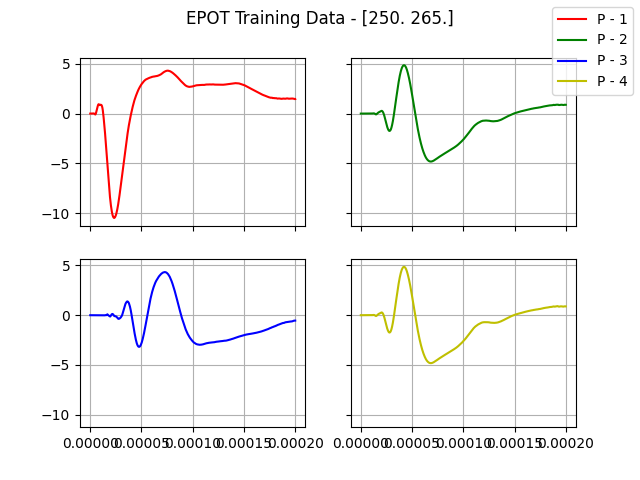

In [6]:
plt.close()
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

l = 3

fig.suptitle(f'EPOT Training Data - {training_tr_labels[l]}')

axs[0,0].plot(training_tr[l][:,0], training_tr[l][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training_tr[l][:,0], training_tr[l][:,2], label='P - 2', c = 'g')
axs[1,0].plot(training_tr[l][:,0], training_tr[l][:,3], label='P - 3', c = 'b')
axs[1,1].plot(training_tr[l][:,0], training_tr[l][:,4], label='P - 4', c = 'y')

fig.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
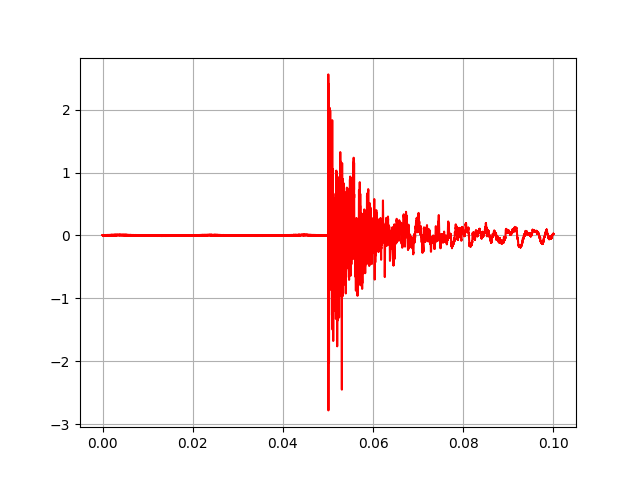

In [7]:
plt.close()
l = 1
plt.plot(ex_data[l][:,0], ex_data[l][:,1], label='P - 1', c = 'r')
plt.show()

##### Parse the experimental validation data

In [8]:
# Initialize lists for training and validation
ex_val_data = []; ex_val_labels = []

#------------------------------------------------------------------------------

for subdir, dirs, files in os.walk(rootdir):
    
    if Ex_Validation.lower() in subdir.lower():
        for file in files:
            if file.endswith('.txt'):
                
                with open(os.path.join(subdir, file), 'r') as f:
                    # print(file.split('_')[2], file.split('_')[3], file.split('_')[5][:3])
                    lbl = [file.split('_')[2], file.split('_')[3], file.split('_')[5][:3]]
                    lb = np.asarray(lbl, dtype=float)

                    x = pd.read_csv(os.path.join(subdir, file), delimiter='\t', decimal=',', skiprows=8, header=None)
                    x = np.asarray(x, dtype=float)
                    ex_val_data.append(x)
                    ex_val_labels.append(lb)

#### Augmentation

##### Variable initialization

In [9]:
## -----------------------------------------------------------------------------
#Assuming P1 on top and counter clockwise order
## -----------------------------------------------------------------------------


# Variables for the augmented data
training_tl = np.zeros_like(np.asarray(training_tr)); training_tl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_bl = np.zeros_like(np.asarray(training_tr)); training_bl_labels = np.zeros_like(np.asarray(training_tr_labels))
training_br = np.zeros_like(np.asarray(training_tr)); training_br_labels = np.zeros_like(np.asarray(training_tr_labels))

##### Top-Left

In [10]:
for i in range (0, len(training_tr)):
        training_tl[i][:,0] = training_tr[i][:,0]
        training_tl[i][:,1] = training_tr[i][:,1]
        training_tl[i][:,2] = training_tr[i][:,4]
        training_tl[i][:,3] = training_tr[i][:,3]
        training_tl[i][:,4] = training_tr[i][:,2]

for i in range (0, len(training_tl_labels)):
    training_tl_labels[i][0] = 500 - training_tr_labels[i][0]
    training_tl_labels[i][1] = training_tr_labels[i][1]

##### Bottom-Left

In [11]:
for i in range (0, len(training_bl)):
    if i in np.where(np.asanyarray(training_tl_labels) == 250.)[0]:
        training_bl[i][:,0] = training_tl[i][:,0]
        training_bl[i][:,1] = training_tl[i][:,1]
        training_bl[i][:,2] = training_tl[i][:,2]
        training_bl[i][:,3] = training_tl[i][:,3]
        training_bl[i][:,4] = training_tl[i][:,4]
    else:
        training_bl[i][:,0] = training_tl[i][:,0]
        training_bl[i][:,1] = training_tl[i][:,3]
        training_bl[i][:,2] = training_tl[i][:,2]
        training_bl[i][:,3] = training_tl[i][:,1]
        training_bl[i][:,4] = training_tl[i][:,4]

for i in range (0, len(training_bl_labels)):
    training_bl_labels[i][0] = 500. - training_tr_labels[i][0]
    training_bl_labels[i][1] = 500. - training_tr_labels[i][1]

##### Bottom-Right

In [12]:
for i in range (0, len(training_br)):
        training_br[i][:,0] = training_bl[i][:,0]
        training_br[i][:,1] = training_bl[i][:,1]
        training_br[i][:,2] = training_bl[i][:,4]
        training_br[i][:,3] = training_bl[i][:,3]
        training_br[i][:,4] = training_bl[i][:,2]

for i in range (0, len(training_br_labels)):
    training_br_labels[i][0] = training_tr_labels[i][0]
    training_br_labels[i][1] = 500 - training_tr_labels[i][1]

##### Delete overlapping data points

In [13]:
training_tl = np.delete(np.asarray(training_tl), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)
training_tl_labels = np.delete(np.asarray(training_tl_labels), np.where(np.asanyarray(training_tl_labels) == 250.)[0], axis = 0)

training_bl = np.delete(np.asarray(training_bl), 0, axis = 0)
training_bl_labels = np.delete(np.asarray(training_bl_labels), 0, axis = 0)

training_br = np.delete(np.asarray(training_br), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)
training_br_labels = np.delete(np.asarray(training_br_labels), np.where(np.asanyarray(training_br_labels) == 250.)[0], axis = 0)

##### Makesure the augmentation is done on all quadrants

In [14]:
print(f'{np.asarray(training_tl).shape} \t{np.asarray(training_tr).shape} \n{np.asarray(training_bl).shape} \t{np.asarray(training_br).shape} \n{counter}')

(219, 20000, 5) 	(244, 20000, 5) 
(243, 20000, 5) 	(219, 20000, 5) 
0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
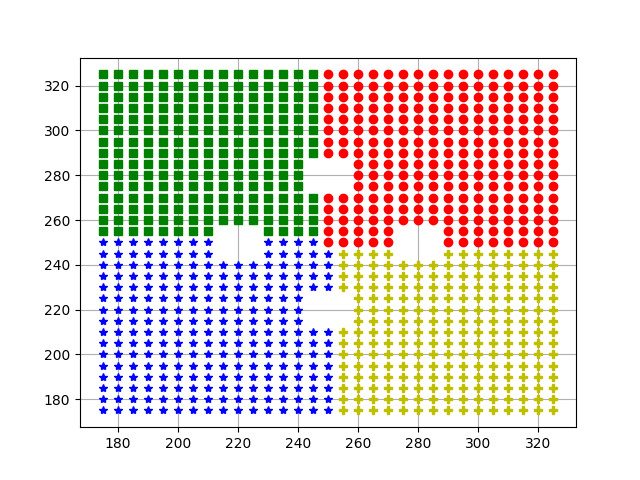

In [15]:
plt.close()
for i in range(0, len(training_tr_labels)):
    plt.plot(training_tr_labels[i][0], training_tr_labels[i][1], 'o', c = 'r')
for j in range (0, len(training_tl_labels)):
    plt.plot(training_tl_labels[j][0], training_tl_labels[j][1], 's', c = 'g')
    plt.plot(training_br_labels[j][0], training_br_labels[j][1], 'P', c = 'y')
for k in range (0, len(training_bl_labels)):
    plt.plot(training_bl_labels[k][0], training_bl_labels[k][1], '*', c = 'b')            

plt.show()

#### Concatenate and normalize

In [16]:
training = np.concatenate((training_tr, training_tl, training_bl, training_br), axis = 0)
training_labels = np.concatenate((training_tr_labels, training_tl_labels, training_bl_labels, training_br_labels), axis = 0)

print(f'Shape of all training set: {training.shape} \nShape of all training labels: {training_labels.shape}')

Shape of all training set: (925, 20000, 5) 
Shape of all training labels: (925, 2)


##### check with the validation augmented data

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
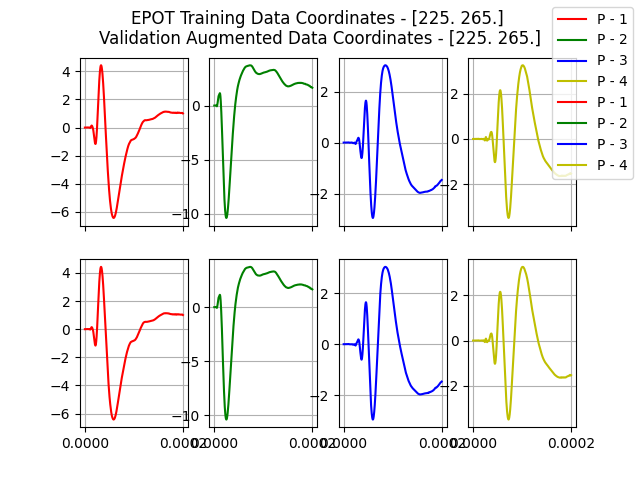

In [17]:
plt.close()
fig, axs = plt.subplots(2, 4, sharex=True)

val_c = 1 # Given validation folder has 4 data points. so use - (0, 1, 2, 3)

# find out the index of the validation set in the training data
x = []
for i in range (0, len(training_labels)):
    if (training_labels[i][0] == validation_aug_labels[val_c][0]) and (training_labels[i][1] == validation_aug_labels[val_c][1]):
        x.append(i)

# plot to compare the validation set with the training set
fig.suptitle(f'EPOT Training Data Coordinates - {training_labels[x[0]]} \nValidation Augmented Data Coordinates - {validation_aug_labels[val_c]}')

axs[0,0].plot(training[x[0]][:,0], training[x[0]][:,1], label='P - 1', c = 'r')
axs[0,1].plot(training[x[0]][:,0], training[x[0]][:,2], label='P - 2', c = 'g')
axs[0,2].plot(training[x[0]][:,0], training[x[0]][:,3], label='P - 3', c = 'b')
axs[0,3].plot(training[x[0]][:,0], training[x[0]][:,4], label='P - 4', c = 'y')

axs[1,0].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,1], label='P - 1', c = 'r')
axs[1,1].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,2], label='P - 2', c = 'g')
axs[1,2].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,3], label='P - 3', c = 'b')
axs[1,3].plot(validation_aug[val_c][:,0], validation_aug[val_c][:,4], label='P - 4', c = 'y')

# check if the data is exactly the same
for i in range (1, 5):
    if np.all(training[x[0]][:,i] == validation_aug[val_c][:,i], axis = 0):
        print('Data is augmented correctly')

fig.legend()
plt.show()

In [18]:
diff = training[x[0]][:,1] - validation_aug[val_c][:,1]
diff

array([0.     , 0.     , 0.     , ..., 0.00011, 0.00012, 0.00012])

##### Normalize

In [19]:
for i in range (0, len(training)):
    for j in range (1, 5):
        training[i][:,j] = minmax_scale(training[i][:,j])

In [20]:
scalar = MinMaxScaler()
scalar.fit(training_labels)
training_labels = scalar.transform(training_labels)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
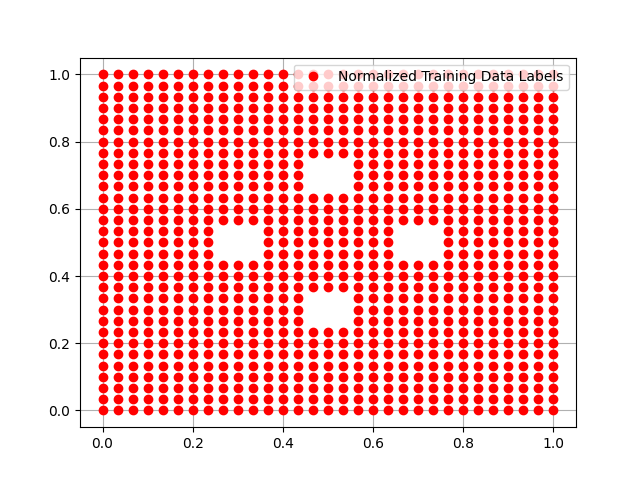

In [21]:
plt.close()
plt.plot(training_labels[:,0], training_labels[:,1], 'o', c = 'r', label = 'Normalized Training Data Labels')
plt.legend()
plt.show()

In [22]:
train_resample = []
for i in range (0, len(training)):
    train_resample.append(pd.DataFrame(training[i], columns = ['time', '1', '2', '3', '4']))
    # drop the time column
    train_resample[i] = train_resample[i].drop(columns = ['time'])

size = 100

for i in range (0, len(training)):
    train_resample[i] = resample(train_resample[i], size)

np.asarray(train_resample).shape

(925, 100, 4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
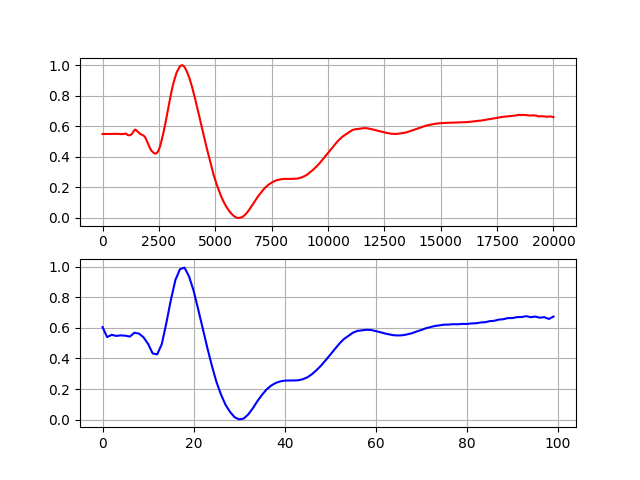

In [23]:
plt.close()
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(training[0][:,1], c = 'r')
axs[1].plot(train_resample[0][:,1], c = 'b')
plt.show()

#### AI Model

In [24]:
size = 0.2

x_train, x_test, y_train, y_test = train_test_split(np.asarray(train_resample), training_labels, shuffle=True, test_size=size)

print(f'Shape of training data - {x_train.shape} \tShape of its labels - {y_train.shape} \nShape of testing data - {x_test.shape} \tShape of its labels - {y_test.shape}')

Shape of training data - (740, 100, 4) 	Shape of its labels - (740, 2) 
Shape of testing data - (185, 100, 4) 	Shape of its labels - (185, 2)


##### Model Initialization

In [25]:
model = Sequential()
model.add(Flatten(input_shape=(100,4)))
model.add(Dense(units=250, activation='relu'))
model.add(Dense(units=50, activation='relu'))
# model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=2, kernel_initializer='normal'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 250)               100250    
                                                                 
 dense_1 (Dense)             (None, 50)                12550     
                                                                 
 dense_2 (Dense)             (None, 2)                 102       
                                                                 
Total params: 112,902
Trainable params: 112,902
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile model
opt = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'mse', optimizer = opt, metrics=['mse', 'mae', 'Accuracy'])

# Fit the model
history = model.fit(x_train, y_train, epochs=40, verbose=1, shuffle=True)

# evaluate the model
pred = model.evaluate(x_test, y_test)

C:\Users\sreekar\anaconda3\envs\ai\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/40
24/24 [==============================] - 1s 5ms/step - loss: 0.1140 - mse: 0.1140 - mae: 0.2859 - Accuracy: 0.5297
Epoch 2/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0928 - mse: 0.0928 - mae: 0.2633 - Accuracy: 0.5149
Epoch 3/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0888 - mse: 0.0888 - mae: 0.2579 - Accuracy: 0.5284
Epoch 4/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0819 - mse: 0.0819 - mae: 0.2466 - Accuracy: 0.5757
Epoch 5/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0742 - mse: 0.0742 - mae: 0.2335 - Accuracy: 0.6392
Epoch 6/40
24/24 [==============================] - 0s 4ms/step - loss: 0.0647 - mse: 0.0647 - mae: 0.2157 - Accuracy: 0.6662
Epoch 7/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0557 - mse: 0.0557 - mae: 0.1950 - Accuracy: 0.7351
Epoch 8/40
24/24 [==============================] - 0s 5ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1737 - Accuracy:

dict_keys(['loss', 'mse', 'mae', 'Accuracy'])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
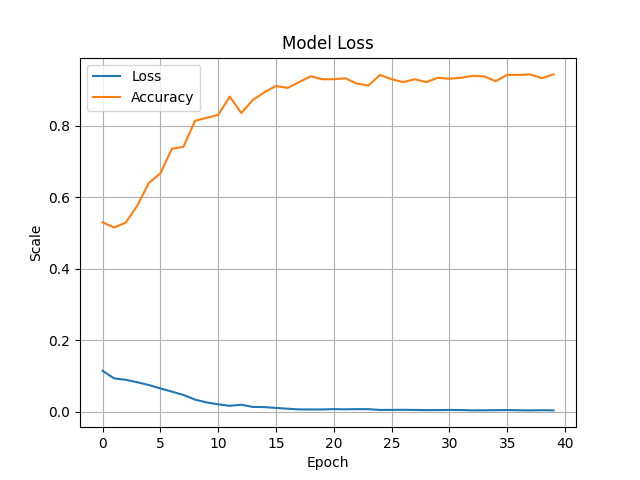

In [27]:
print(history.history.keys())
# "Loss"
plt.close()
plt.plot(history.history['loss'])
plt.plot(history.history['Accuracy'])
plt.title('Model Loss')
plt.ylabel('Scale')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Accuracy'], loc='upper left')
plt.show()

#### Predict for experimental data validation

In [28]:
freq = 1/(ex_val_data[0][:,0][1] - ex_val_data[0][:,0][0]) 
# freq = np.round(len(ex_val_data[0][:,0])/(ex_val_data[0][:,0][-1]))
peaks, _ = find_peaks(ex_val_data[0][:,1], height = 1) # , distance = freq*0.0001
peaks2, _ = find_peaks(ex_val_data[0][:,2], height = 1)
peaks3, _ = find_peaks(ex_val_data[0][:,3], height = 1)
print(peaks, peaks2, peaks3)

[50040 50069 50132 50337 50358 50384 50410 50442 50457 50491 50533 50595
 50663 50699 50741 50939 51079 51803 51848 52661 52681 52701 52717 52735
 53137 53294 55674 55690 55714 55746 55783] [50001 50024 50106 50135 50162 51042 51079 51222 51661 51797 51919 51958
 52181 52319 52345 52448 52819 53093 53381 53772 53870 54016 54044 54567
 55498 55512 55526 56090 56106 56117 59863 59882 59893] [50037 50064 50124 50325 50347 50368 50395 50404 50432 50467 50491 50538
 50588 50654 50664 50743 50849 51047 51661 52328 52662 52688 52745 54108
 54261 55506 55512 55529 55541 55742 55775 58843]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
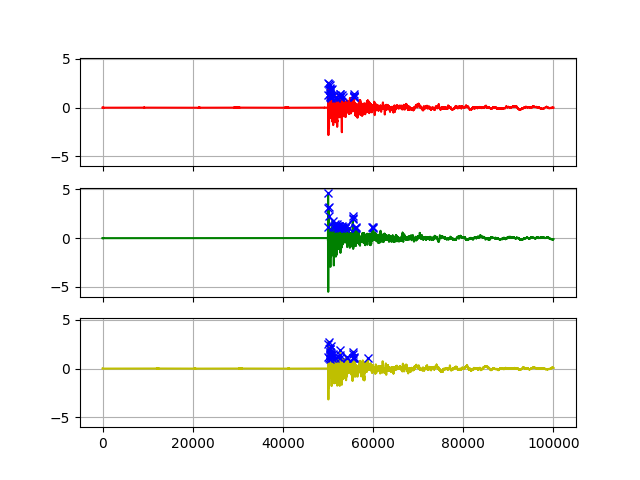

In [29]:
plt.close()
fig, axs = plt.subplots(3, 1, sharex = True, sharey=True)

axs[0].plot(ex_val_data[0][:,1], c = 'r', label = f'Experimental Validation Data {ex_val_labels[0]}')
axs[0].plot(peaks, ex_val_data[0][:,1][peaks], 'x', label = 'Peaks', c = 'b')

axs[1].plot(ex_val_data[0][:,2], c = 'g', label = f'Experimental Validation Data {ex_val_labels[1]}')
axs[1].plot(peaks2, ex_val_data[0][:,2][peaks2], 'x', label = 'Peaks', c = 'b')

axs[2].plot(ex_val_data[0][:,3], c = 'y', label = f'Experimental Validation Data {ex_val_labels[2]}')
axs[2].plot(peaks3, ex_val_data[0][:,3][peaks3], 'x', label = 'Peaks', c = 'b')

plt.show()

In [30]:
check = ex_val_data[0][:,1][peaks[1]:peaks[3]]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
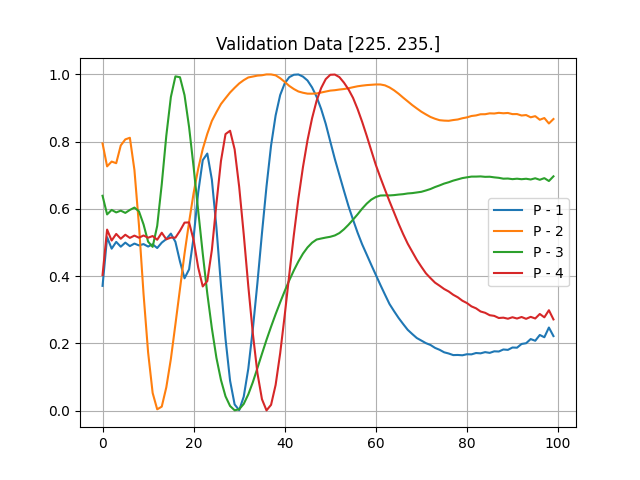

In [31]:
c = []
checking1 = validation_aug[0][:,1:5]
checking1 = minmax_scale(checking1)
checking1 = resample(checking1, 100)

checking2 = validation_aug[1][:,1:5]
checking2 = minmax_scale(checking2)
checking2 = resample(checking2, 100)

c.append(checking1)
c.append(checking2)

plt.close()
plt.title(f'Validation Data {validation_aug_labels[0]}')
plt.plot(checking1[:,0], label = 'P - 1')
plt.plot(checking1[:,1], label = 'P - 2')
plt.plot(checking1[:,2], label = 'P - 3')
plt.plot(checking1[:,3], label = 'P - 4')
plt.legend()
plt.show()

In [32]:
print(f'{validation_aug_labels[0]} \n{validation_aug_labels[1]}')

p = model.predict(np.asarray(c))
# print(p)
p = scalar.inverse_transform(p)
print(p)

print(f'Difference between the actual and predicted coordinates: \n{validation_aug_labels[0][0]-p[0][0]} {validation_aug_labels[0][1]-p[0][1]}\n {validation_aug_labels[1][0]-p[1][0]} {validation_aug_labels[1][1]-p[1][1]}')

[225. 235.] 
[225. 265.]
[[219.03642 236.61855]
 [216.9375  271.48615]]
Difference between the actual and predicted coordinates: 
5.9635772705078125 -1.6185455322265625
 8.0625 -6.48614501953125


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
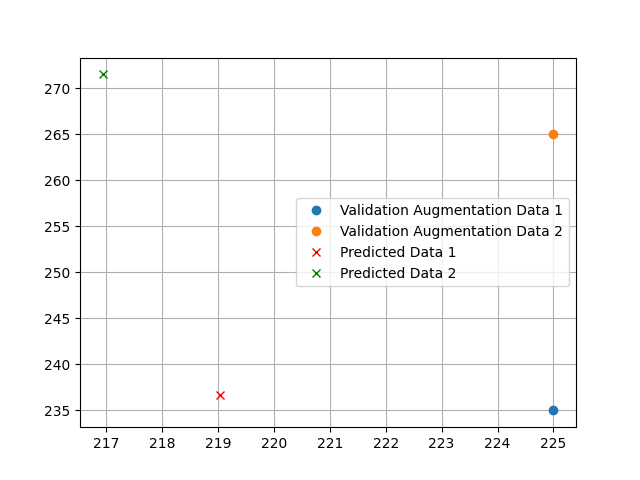

In [33]:
plt.close()
plt.plot(validation_aug_labels[0][0], validation_aug_labels[0][1], 'o' , label = 'Validation Augmentation Data 1')
plt.plot(validation_aug_labels[1][0], validation_aug_labels[1][1], 'o' , label = 'Validation Augmentation Data 2')

plt.plot(p[0][0], p[0][1], 'x' , c = 'r' , label = 'Predicted Data 1')
plt.plot(p[1][0], p[1][1], 'x' , c = 'g' , label = 'Predicted Data 2')

plt.legend()
plt.show()